In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing,metrics
import sys

%matplotlib inline

In [2]:
#descriptions of features
!cat data/kaggle_data/features.txt

nb_words_title  Number of words in the article's titles
nb_words_content  Number of words in the article
pp_uniq_words  Proportion of unique words in the article
pp_stop_words  Proportion of stop words (i.e. words predefined to be too common to be of use for interpretation or queries, such as 'the', 'a', 'and', etc.)
pp_uniq_non-stop_words  Proportion of non-stop words among unique words
nb_links  Number of hyperlinks in the article
nb_outside_links  Number of hyperlinks pointing to another website
nb_images  Number of images in the article
nb_videos  Number of videos in the article
ave_word_length  Average word length
nb_keywords  Number of keywords in the metadata
category  Category of the article: 0-Lifestyle, 1-Entertainment, 2-Business, 3-Web, 4-Tech, 5-World
nb_mina_mink  Minimum number of share counts among all articles with at least one keyword in common with the article
nb_mina_maxk  Minimum number of maximum share counts per keyword
nb_mina_avek  Minimum number of average sha

In [19]:
feature_data = pd.read_csv('data/kaggle_data/features.txt', header=None, sep="  ", names=['feature_names', 'feature_description'])
target_data = pd.read_csv('data/kaggle_data/train-targets.csv', sep=",")
target_data.head(5)
y_tr = target_data['Prediction'].values
list_feature_names = list(feature_data['feature_names'])
train_data = pd.read_csv('data/kaggle_data/train.csv', header=None, sep=" ", names=list_feature_names)
train_data.head(5)
test_data = pd.read_csv('data/kaggle_data/test-val.csv', header=None, sep=" ", names=list_feature_names)
test_data.head(5)

/Users/XQ/envs/scipy35/lib/python3.5/site-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


,nb_words_title,nb_words_content,pp_uniq_words,pp_stop_words,pp_uniq_non-stop_words,nb_links,nb_outside_links,nb_images,nb_videos,ave_word_length,...,pp_neg_words,pp_pos_words_in_nonneutral,ave_polar_pos,min_polar_pos,max_polar_pos,ave_polar_neg,min_polar_neg,max_polar_neg,subj_title,polar_title
0,12,258,0.5745,6.897000e-09,0.6897,4.0,2,0,0,4,...,0.01653,0.7143,0.2967,0.10000,1.0,-0.2344,-0.3,-0.1875,0.125,0.0
1,8,11,0.0000,1.000000e+00,0.0000,0.0,0,0,0,0,...,0.00000,0.0000,0.0000,0.00000,0.0,0.0000,0.0,0.0000,0.525,0.3
2,10,263,0.7249,6.623000e-09,0.8543,6.0,3,2,0,5,...,0.04701,0.5000,0.2617,0.10000,1.0,-0.2170,-0.5,-0.1250,0.000,-0.2
3,13,1281,0.4067,1.422000e-09,0.5903,29.0,4,1,1,4,...,0.01512,0.7500,0.3585,0.03333,1.0,-0.2403,-0.5,-0.0500,0.000,0.0
4,9,107,0.8152,1.538000e-08,0.8154,5.0,2,0,0,4,...,0.02151,0.6667,0.4881,0.28570,1.0,-0.8000,-1.0,-0.6000,0.000,0.0


In [4]:
#transform labels to log space
def label_transform(k,b,labels):
    return np.log(k*labels+b)

#transforms logspace predictions back to linear space
def inv_label_transform(k,b,log_pred):
    return (np.exp(log_pred)-b)/k

In [20]:
#feature engineering and label engineering

import math
#Binarizing weekday data into working/non-working days 0-4 weekdays, 5 or 6 weekends
def binarize_weekends(dataframe):
    days = list(dataframe['weekday'])
    is_weekend = [0 if day in [0,1,2,3,4] else 1 for day in days]
    dataframe['weekday']=is_weekend
    return dataframe

#doing a continuous sine transfrm on the periodic weekday data
def transform_weekdays(dataframe):
    days = list(dataframe['weekday'])
    cont_days = [math.sin(2*day*math.pi/7) for day in days]
    print(cont_days)
    dataframe['weekday']=cont_days
    return dataframe

#removing strongly correlated features, i.e. pp_uniq_words'<-> 'pp_uniq_non-stop_words'), ('nb_links'<-> 'nb_outside_links'), ('nb_mina_maxk'<-> 'nb_mina_avek')
dropped_col_list=['pp_uniq_non-stop_words','nb_outside_links','nb_mina_avek']
#dropped_col_list=[]
b=0
k=100
y_tr = target_data['Prediction'].values
y_tr = label_transform(k,b,y_tr)
train_data = binarize_weekends(train_data)
test_data = binarize_weekends(test_data)
#train_data = transform_weekdays(train_data)
#test_data = transform_weekdays(test_data)
train_data = train_data.drop(dropped_col_list,axis=1)
test_data = test_data.drop(dropped_col_list,axis=1)
#print(test_data['weekday'])



In [21]:

# Get the weekday data and encode it using a dummy categorical encoding
"""
weekday_data = pd.get_dummies(train_data['weekday'], prefix='weekday', drop_first=True)
other_data = train_data.drop(['weekday'], axis=1)
train_data = pd.concat([weekday_data, other_data], axis=1)

weekday_data = pd.get_dummies(test_data['weekday'], prefix='weekday', drop_first=True)
other_data = test_data.drop(['weekday'], axis=1)
test_data = pd.concat([weekday_data, other_data], axis=1)

"""

category_data = pd.get_dummies(train_data['category'], prefix='cat', drop_first=True)
other_data = train_data.drop(['category'], axis=1)
train_data = pd.concat([category_data, other_data], axis=1)


category_data = pd.get_dummies(test_data['category'], prefix='cat', drop_first=True)
other_data = test_data.drop(['category'], axis=1)
test_data = pd.concat([category_data, other_data], axis=1)


In [473]:
train_data.head(5)

,cat_1,cat_2,cat_3,cat_4,cat_5,nb_words_title,nb_words_content,pp_uniq_words,pp_stop_words,pp_uniq_non-stop_words,...,pp_neg_words,pp_pos_words_in_nonneutral,ave_polar_pos,min_polar_pos,max_polar_pos,ave_polar_neg,min_polar_neg,max_polar_neg,subj_title,polar_title
2000,1,0,0,0,0,9,843,0.5358,2.092000e-09,0.7469,...,0.019230,0.7143,0.4437,0.03333,1.0,-0.3160,-0.8000,-0.05,0.0,0.0
2001,0,0,0,0,1,9,805,0.4196,2.165000e-09,0.5693,...,0.025710,0.5349,0.3081,0.05000,0.8,-0.3463,-0.7143,-0.10,0.9,0.3
2002,0,0,0,1,0,8,145,0.7594,1.163000e-08,0.8488,...,0.007519,0.8333,0.3673,0.13640,0.5,-0.2000,-0.2000,-0.20,0.0,0.0
2003,0,0,0,1,0,12,201,0.6359,9.259000e-09,0.8148,...,0.027030,0.7368,0.3721,0.13640,0.6,-0.4000,-0.4000,-0.40,0.0,0.0
2004,0,0,0,0,1,13,673,0.4609,2.500000e-09,0.5950,...,0.021440,0.5625,0.3500,0.05000,0.6,-0.2435,-0.8000,-0.10,0.0,0.0


In [474]:
# Cross-validation procedure, with standardization
def cross_validate_regr_with_scaling(design_matrix, labels, regressor, cv_folds):
    """ Perform a cross-validation and returns the predictions. 
    Use a scaler to scale the features to mean 0, standard deviation 1.
    
    Parameters:
    -----------
    design_matrix: (n_samples, n_features) np.array
        Design matrix for the experiment.
    labels: (n_samples, ) np.array
        Vector of labels.
    classifier:  Regressor instance; must have the following methods:
        - fit(X, y) to train the regressor on the data X, y
        - predict_proba(X) to apply the trained regressor to the data X and return predicted values
    cv_folds: sklearn cross-validation object
        Cross-validation iterator.
        
    Return:
    -------
    pred: (n_samples, ) np.array
        Vectors of predictions (same order as labels).
    """
    
    pred = np.zeros(labels.shape)
    pca = decomposition.PCA(n_components=30)
    scaler = preprocessing.StandardScaler()
    pca.fit(design_matrix)
    for tr, te in cv_folds:
        Xtr = scaler.fit_transform(design_matrix[tr,:])
        Xtr = pca.transform(Xtr)
        ytr = labels[tr]
        Xte = scaler.transform(design_matrix[te,:])
        Xte = pca.transform(Xte)
        regressor.fit(Xtr, ytr)
        pred[te] = regressor.predict(Xte)
    return pred

In [7]:
#create folds
from sklearn import cross_validation

X_tr = train_data.values
X_te = test_data.values
print(X_te.shape)
folds_regr = cross_validation.StratifiedKFold(y_tr,n_folds=5,shuffle=True)


/Users/XQ/envs/scipy35/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/XQ/envs/scipy35/lib/python3.5/site-packages/sklearn/cross_validation.py:553: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=5.
  % (min_labels, self.n_folds)), Warning)


(2000, 43)


In [476]:
from sklearn.model_selection import GridSearchCV

from sklearn import linear_model
param_grid = {'alpha': np.logspace(-4, 4, 20)}
"""
regr_lasso_stand = linear_model.LinearRegression(fit_intercept=True)
ypred_lasso_stand = cross_validate_regr_with_scaling(X_tr, y_tr, regr_lasso_stand, folds_regr)
ypred_lasso_stand = np.where(ypred_lasso_stand>0,ypred_lasso_stand,0)
print(metrics.mean_squared_log_error(y_tr,ypred_lasso_stand))
#print(regr_lasso_stand.predict(X_te))
#print("with standardization; RMSE: ", np.sqrt(metrics.mean_squared_error(y_te,
#                                                                      ypred_lasso_stand)))

np.random.seed(5)
regr_ridge_stand_opt = GridSearchCV(linear_model.Ridge(), param_grid, scoring='neg_mean_squared_error')
ypred_ridge_stand_opt = cross_validate_regr_with_scaling(X_tr,y_tr,regr_ridge_stand_opt,folds_regr)
ypred_ridge_stand_opt = np.where(ypred_ridge_stand_opt>0,ypred_ridge_stand_opt,0)
print("with scaling:", metrics.mean_squared_log_error(y_tr,ypred_ridge_stand_opt), 'alpha: ', regr_lasso_stand_opt.best_params_['alpha'])
"""
blist = [-200,-100,100,200,300,400]

np.random.seed(5)
regr_lasso_stand_opt = GridSearchCV(linear_model.Lasso(), param_grid,scoring='neg_mean_squared_log_error')
ypred_lasso_stand_opt_raw = cross_validate_regr_with_scaling(X_tr, y_tr, regr_lasso_stand_opt, folds_regr)
#ypred_lasso_stand_opt = np.where(ypred_lasso_stand_opt_raw>0,ypred_lasso_stand_opt_raw,0)
print("with standardization; RMSLE: ", np.sqrt(metrics.mean_squared_log_error(inv_label_transform(k,b,y_tr),
                                                                       inv_label_transform(k,b,ypred_lasso_stand_opt_raw))),'; alpha: ', regr_lasso_stand_opt.best_params_['alpha'])

with standardization; RMSLE:  0.86757293221 ; alpha:  0.00483293023857


In [477]:
ypred_lasso_stand_opt=inv_label_transform(k,b,ypred_lasso_stand_opt_raw)
print(ypred_lasso_stand_opt[:10])
print(max(ypred_lasso_stand_opt))

[ 1424.09713234  1327.00544761  1890.59455232  1686.37122039  1387.28238089
  2225.49069067  1099.32947858  1122.14302025  2318.21518026  2644.29890163]
348396.182252


[ 0.13192113  0.08634351  0.06351996  0.06338384  0.05522427  0.05246681
  0.04845902  0.04579258  0.0422531   0.03488187  0.03015276  0.02816987
  0.02731671  0.02344791  0.02288483  0.02207631  0.02088923  0.01906112
  0.01847821  0.01638283  0.01568692  0.01400303  0.01327824  0.01208997
  0.01130565  0.01095617  0.00951491  0.00890497  0.00731478  0.0066364 ]


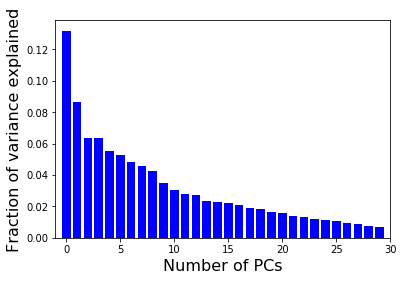

In [478]:
from sklearn import decomposition

std_scale = preprocessing.StandardScaler().fit(X_tr)
X_scaled = std_scale.transform(X_tr)

n_pcs = 30

pca = decomposition.PCA(n_components=n_pcs)
pca.fit(X_scaled)
X_projected = pca.transform(X_scaled)
print(pca.explained_variance_ratio_)
plt.bar(np.arange(n_pcs), pca.explained_variance_ratio_, color='blue')
plt.xlim([-1, n_pcs])
plt.xlabel("Number of PCs", fontsize=16)
plt.ylabel("Fraction of variance explained", fontsize=16)

In [ ]:
print(max(ypred_lasso_stand_opt))

In [ ]:
print(max(y_tr))

In [482]:
pca = decomposition.PCA(n_components=30)
scaler = preprocessing.StandardScaler()
pca.fit(X_tr)
pred = regr_lasso_stand_opt.predict(pca.transform(scaler.fit_transform(X_te)))
pred = inv_label_transform(k,b,pred)
print(pred.shape)
pred_int = list(map(int, np.where(pred>0,pred,0)))
print(max(np.array(pred_int)))
print(min(np.array(pred_int)))
pred_df = pd.DataFrame()
pred_df['Prediction'] = pred_int
pred_df.head(5)

(2000,)
120470
981


,Prediction
0,1415
1,1877
2,1544
3,2389
4,2031


In [480]:
print(max(pred_df.values))

[16]


In [483]:
pred_df.to_csv('lasso_v2.csv')

In [9]:
#start of nearest neighbors prediction
import math
from sklearn import neighbors
from sklearn import model_selection

regressor = neighbors.KNeighborsRegressor()
param_grid = {'n_neighbors':range(10,100,10) }
print(param_grid)
clf_knn_opt = model_selection.GridSearchCV(regressor,  param_grid=param_grid, cv=folds_regr,scoring='neg_mean_squared_log_error')
clf_knn_opt.fit(X_tr,y_tr)


{'n_neighbors': range(10, 100, 10)}


GridSearchCV(cv=sklearn.cross_validation.StratifiedKFold(labels=[ 11.38736  11.61005 ...,  11.40978  11.69857], n_folds=5, shuffle=True, random_state=None),
       error_score='raise',
       estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=5, p=2,
          weights='uniform'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_neighbors': range(10, 100, 10)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_log_error', verbose=0)

In [10]:
print(clf_knn_opt.best_params_)

{'n_neighbors': 60}


In [12]:
def cross_validate(design_matrix, labels, regressor, cv_folds):
    """ Perform a cross-validation and returns the predictions. 
    Use a scaler to scale the features to mean 0, standard deviation 1.
    
    Parameters:
    -----------
    design_matrix: (n_samples, n_features) np.array
        Design matrix for the experiment.
    labels: (n_samples, ) np.array
        Vector of labels.
    classifier:  Regressor instance; must have the following methods:
        - fit(X, y) to train the regressor on the data X, y
        - predict_proba(X) to apply the trained regressor to the data X and return predicted values
    cv_folds: sklearn cross-validation object
        Cross-validation iterator.
        
    Return:
    -------
    pred: (n_samples, ) np.array
        Vectors of predictions (same order as labels).
    """
    #labels = np.array(labels)
    n_classes = np.unique(labels).size
   # print(labels.shape[0])
    pred = np.zeros(labels.shape[0])
    for tr, te in cv_folds:
        scaler = preprocessing.StandardScaler()
        Xtr = scaler.fit_transform(design_matrix[tr,:])
        ytr =  labels[tr]
        Xte = scaler.transform(design_matrix[te,:])
        regressor.fit(Xtr, ytr)
        prediction = regressor.predict(Xte)
        pred[te] = prediction
    return pred

ypred_clf_knn_opt = cross_validate(X_tr,y_tr,clf_knn_opt.best_estimator_,folds_regr)
print(ypred_clf_knn_opt.shape)
print(metrics.mean_squared_log_error(inv_label_transform(k,b,y_tr),inv_label_transform(k,b,ypred_clf_knn_opt)))
print(max(ypred_clf_knn_opt))


(5000,)
0.765300388074
12.9522688025


In [22]:
#START OF RANDOM FORESTS
from sklearn import ensemble
def cross_validate_reg_optimize(design_matrix, labels, regressor, cv_folds):
    """ Perform a cross-validation and returns the predictions.
    
    Parameters:
    -----------
    design_matrix: (n_samples, n_features) np.array
        Design matrix for the experiment.
    labels: (n_samples, ) np.array
        Vector of labels.
    classifier:  sklearn classifier object
        Classifier instance; must have the following methods:
        - fit(X, y) to train the classifier on the data X, y
        - predict_proba(X) to apply the trained classifier to the data X and return probability estimates 
    cv_folds: sklearn cross-validation object
        Cross-validation iterator.
        
    Return:
    -------
    pred: (n_samples, ) np.array
        Vectors of predictions (same order as labels).
    """
    pred = np.zeros(labels.shape)
    for tr, te in cv_folds:
        scaler = preprocessing.StandardScaler()
        Xtr = scaler.fit_transform(design_matrix[tr,:])
        ytr =  labels[tr]
        Xte = scaler.transform(design_matrix[te,:])
        regressor.fit(Xtr, ytr)
        print(regressor.best_params_)
        prediction = regressor.best_estimator_.predict(Xte)
        pred[te] = prediction
    return pred

rf = ensemble.RandomForestRegressor(n_estimators=200)
param_grid = {'max_features':[2,4,6,8,10,12,14,16,18,20]}
regr_rf = model_selection.GridSearchCV(rf,param_grid=param_grid,scoring='neg_mean_squared_log_error')
ypred_rf_opt = cross_validate_reg_optimize(X_tr,y_tr,regr_rf,folds_regr)
print(max(ypred_rf_opt))
print(metrics.mean_squared_log_error(inv_label_transform(k,b,y_tr),inv_label_transform(k,b,ypred_rf_opt)))
"""
bt = ensemble.BaggingRegressor(n_estimators=100)
param_grid = {'max_features':[7]}
regr_bt = model_selection.GridSearchCV(bt,param_grid=param_grid,scoring='neg_mean_squared_error')
ypred_bt_opt = cross_validate_reg_optimize(X_tr,y_tr,regr_bt,folds_regr)
print(max(ypred_bt_opt))
print(metrics.mean_squared_log_error(y_tr,ypred_bt_opt))
"""

{'max_features': 10}
{'max_features': 20}
{'max_features': 2}
{'max_features': 2}
{'max_features': 2}
13.2871775073
0.732215782379


"\nbt = ensemble.BaggingRegressor(n_estimators=100)\nparam_grid = {'max_features':[7]}\nregr_bt = model_selection.GridSearchCV(bt,param_grid=param_grid,scoring='neg_mean_squared_error')\nypred_bt_opt = cross_validate_reg_optimize(X_tr,y_tr,regr_bt,folds_regr)\nprint(max(ypred_bt_opt))\nprint(metrics.mean_squared_log_error(y_tr,ypred_bt_opt))\n"

In [18]:
print(np.sqrt(metrics.mean_squared_log_error(inv_label_transform(k,b,y_tr),inv_label_transform(k,b,ypred_rf_opt))))
ypred_rf_opt_1 = inv_label_transform(k,b,ypred_rf_opt)
print(max(ypred_rf_opt_1))
print(regr_rf.best_params_)
#print(np.sort(y_tr[:20]))

0.854182596665
6781.46583104
{'max_features': 2}


In [505]:
scaler = preprocessing.StandardScaler()
pred = regr_rf.predict(scaler.fit_transform(X_te))
pred = inv_label_transform(k,b,pred)
print(pred.shape)
pred_int = list(map(int, np.where(pred>0,pred,0)))
print(max(np.array(pred_int)))
print(min(np.array(pred_int)))
pred_rf = pd.DataFrame()
pred_rf['Prediction'] = pred_int
pred_rf.head(5)

(2000,)
5327
861


,Prediction
0,1563
1,2116
2,1544
3,2159
4,2265


In [506]:
pred_rf.to_csv('rf_super.csv')

In [ ]:
print(max(test))

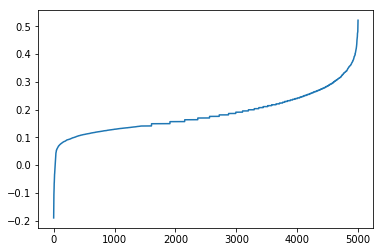

In [356]:
plt.plot(np.log(0.1*np.sort(y_tr)))